# Bidirectional LSTM

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import mne
import os
import sys
from mne.datasets import eegbci
import glob
from IPython.display import clear_output
import numpy as np
import torch
from torch import nn
import torch.optim as optim

from mne.datasets import eegbci
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
from scipy import signal

## Data Preprocessing
* Copy class from preprocessing file

In [6]:
class EEG:
    def __init__(self, path, base_url, subjects, runs):
        self.subpath = 'datasets' #ensure this path is correct
        self.path = path
        self.base_url = base_url
        self.subjects = subjects
        self.runs = runs
        
        # download data if does not exist in path.
        # self.load_data() #uncomment if you need to download new data
        self.data_to_raw()
    
    def load_data(self):
        print(f">>> Start download from: {self.base_url}.")
        print(f"Downloading files to: {self.path}.")
        for subject in self.subjects:
            eegbci.load_data(subject,self.runs,path=self.path,base_url=self.base_url)
        print("Done.")
    
    def data_to_raw(self):
        fullpath = os.path.join(self.path, *self.subpath.split(sep='/'))
        print(f">>> Extract all subjects from: {fullpath}.")
        extension = "edf"
        raws = []
        count = 1
        for i, subject in enumerate(self.subjects):
            sname = f"S{str(subject).zfill(3)}".upper()
            for j, run in enumerate(self.runs):
                rname = f"{sname}R{str(run).zfill(2)}".upper()
                path_file = os.path.join(fullpath, sname, f'{rname}.{extension}')
                print(f"Loading file #{count}/{len(self.subjects)*len(self.runs)}: {f'{rname}.{extension}'}")
                raw = mne.io.read_raw_edf( path_file , preload=True, verbose='WARNING' )
                raws.append(raw)
                count += 1

        raw = mne.io.concatenate_raws(raws)
        eegbci.standardize(raw)
        montage = mne.channels.make_standard_montage('standard_1005')
        raw.set_montage(montage)
        self.raw = raw
        print("Done.")
    
    def filter(self, freq):
        low, high = freq
        print(f">>> Apply filter.")
        self.raw.filter(low, high, fir_design='firwin', verbose=20)
        
    def get_events(self):
        event_id = dict(T1=0, T2=1) # the events we want to extract
        events, event_id = mne.events_from_annotations(self.raw, event_id=event_id)
        return events, event_id
    
    def get_epochs(self, events, event_id):
        picks = mne.pick_types(self.raw.info, eeg=True, exclude='bads')
        tmin = 0
        tmax = 4
        epochs = mne.Epochs(self.raw, events, event_id, tmin, tmax, proj=True, 
                            picks=picks, baseline=None, preload=True)
        return epochs
    
    def create_epochs(self):
        print(">>> Create Epochs.")
        events, event_id = self.get_events()
        self.epochs = self.get_epochs(events, event_id)
        print("Done.")
    
    def get_X_y(self):
        if self.epochs is None:
            self.create_epochs()
        self.X = self.epochs.get_data()
        self.y = self.epochs.events[:, -1]
        return self.X, self.y

In [214]:
# home directory + datasets folder
path = '' #change to where the dataset is stored
base_url = 'https://physionet.org/files/eegmmidb/1.0.0/'
# subjects = [1]
runs = [3,4, 7,8, 11,12] # only take the trials where left and right fist is involved
subjects = [i for i in range(1, 21)]

eeg = EEG(path, base_url, subjects, runs)

# apply filter
freq = (1., 40.) #bandpass filter values
eeg.filter(freq=freq)

eeg.create_epochs()

>>> Extract all subjects from: datasets.
Loading file #1/120: S001R03.edf
Loading file #2/120: S001R04.edf
Loading file #3/120: S001R07.edf
Loading file #4/120: S001R08.edf
Loading file #5/120: S001R11.edf
Loading file #6/120: S001R12.edf
Loading file #7/120: S002R03.edf
Loading file #8/120: S002R04.edf
Loading file #9/120: S002R07.edf
Loading file #10/120: S002R08.edf
Loading file #11/120: S002R11.edf
Loading file #12/120: S002R12.edf
Loading file #13/120: S003R03.edf
Loading file #14/120: S003R04.edf
Loading file #15/120: S003R07.edf
Loading file #16/120: S003R08.edf
Loading file #17/120: S003R11.edf
Loading file #18/120: S003R12.edf
Loading file #19/120: S004R03.edf
Loading file #20/120: S004R04.edf
Loading file #21/120: S004R07.edf
Loading file #22/120: S004R08.edf
Loading file #23/120: S004R11.edf
Loading file #24/120: S004R12.edf
Loading file #25/120: S005R03.edf
Loading file #26/120: S005R04.edf
Loading file #27/120: S005R07.edf
Loading file #28/120: S005R08.edf
Loading file #29

In [215]:
print(eeg.raw.ch_names[1])
print(eeg.raw.ch_names[5])

FC3
FC4


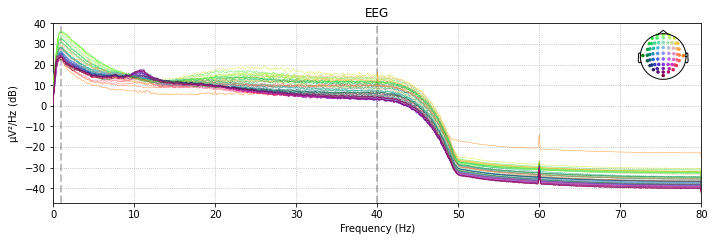

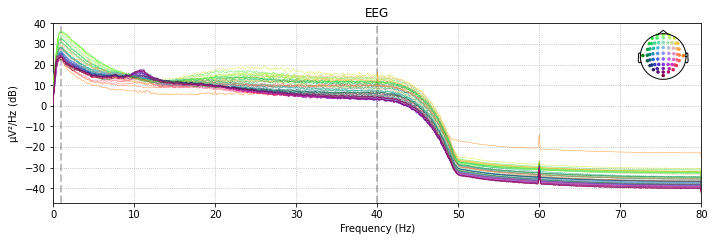

In [216]:
eeg.raw.plot_psd()

## Prepare Data

In [217]:
X, y = eeg.get_X_y()

print(X.shape, y.shape)

X = X[:,:,:]
print(X.shape)

X2 = X[:, 1:2, :] 
print(X2.shape)

X3= X[:, 5:6, :]
print(X3.shape)

X4 = np.concatenate((X2,X3), axis=1)
print(X4.shape)

X_new = X4 # X_new is only for 2 channels FC3, FC4

(1800, 64, 641) (1800,)
(1800, 64, 641)
(1800, 1, 641)
(1800, 1, 641)
(1800, 2, 641)


In [298]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, num_classes, bidirectional, dropout):
        super(LSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, bidirectional=bidirectional, 
                            dropout=dropout, batch_first=batch_first)
        # fully connected layer (64, 2)
        self.fc = nn.Linear(hidden_dim * num_layers, num_classes)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, x):
        # self.num_layers*2 because Direction=2, change to 1 for Uni and set to False
        h0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_dim).to(device).float()
        c0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_dim).to(device).float()
        
        # Forward propagate LSTM
        out, _ = self.lstm(x, (h0, c0)) # out: tensor of shape (batch_size, seq_length, hidden_size)
        
        # Extract hidden state of final h
        out = self.fc(out[:, -1, :]) 
        out = self.softmax(out)

        return out

In [315]:
input_dim = 64
hidden_dim = 128
num_layers = 2
num_classes = 2
bidirectional = True
batch_first = True
dropout = 0.25

#LSTM
model_lstm = LSTM(input_dim, hidden_dim, num_layers, num_classes, bidirectional, dropout)
model_lstm = model_lstm.float()

In [316]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model {type(model_lstm).__name__} has {count_parameters(model_lstm):,} trainable parameters')# Train the model


The model LSTM has 594,434 trainable parameters


In [317]:
model_lstm

LSTM(
  (lstm): LSTM(64, 128, num_layers=2, batch_first=True, dropout=0.25, bidirectional=True)
  (fc): Linear(in_features=256, out_features=2, bias=True)
  (softmax): LogSoftmax(dim=1)
)

In [302]:
import torch.optim as optim

learning_rate = 0.0001

# optimizer = optim.Adam(model_lstm.parameters())
criterion = nn.NLLLoss()
optimizer = torch.optim.SGD(model_lstm.parameters(), lr=learning_rate)

In [303]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Configured device: ", device)

Configured device:  cuda


In [304]:
model_lstm = model_lstm.to(device)
criterion = criterion.to(device)

Change argument here to X_new if you want the 2 best EEG electrodes (FC3 and FC4 according to the paper) otherwise X if you want all 64 electrodes.

In [305]:
torch_X = torch.from_numpy(X_new)
torch_y = torch.from_numpy(y)

In [306]:
print("Original X: ", torch_X.size())

Original X:  torch.Size([1800, 64, 641])


In [307]:
torch_X_reshaped = torch_X.permute(0, 2, 1)
print("Converted X: ", torch_X_reshaped.size())

Converted X:  torch.Size([1800, 641, 64])


In [308]:
from torch.utils.data import TensorDataset

# Define dataset
ds = TensorDataset(torch_X_reshaped, torch_y)

#Train test split
train_size = int(torch_X_reshaped.size()[0] * 0.7)
valid_size = int(torch_X_reshaped.size()[0] * 0.3)

train_set, valid_set = torch.utils.data.random_split(ds, [train_size, valid_size])

BATCH_SIZE = 128

#Train set loader
train_iterator = torch.utils.data.DataLoader(dataset=train_set, 
                                           batch_size=BATCH_SIZE, 
                                           shuffle=True)
#Validation set loader
valid_iterator = torch.utils.data.DataLoader(dataset=valid_set, 
                                           batch_size=BATCH_SIZE, 
                                           shuffle=True)



In [309]:
def train(model, iterator, optimizer, criterion):
    total = 0
    correct = 0
    epoch_loss = 0
    epoch_acc = 0
    
    model.train()
    
    for batch, labels in iterator:
        
        #Move tensors to the configured device
        batch = batch.to(device).long()
        labels = labels.to(device).long()

        #Forward pass
        outputs = model(batch.float())
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
                
        #check accuracy
        predictions = model(batch.float())
        _, predicted = torch.max(predictions.data, 1)  #returns max value, indices
        total += labels.size(0)  #keep track of total
        correct += (predicted == labels).sum().item()  #.item() give the raw number
#         print("total:", total)
#         print("correct:", correct)
        acc = 100 * (correct / total)
                
        epoch_loss += loss.item()
        epoch_acc = acc
        
    return epoch_loss / len(iterator), epoch_acc

In [310]:
def evaluate(model, iterator, criterion):
    
    total = 0
    correct = 0
    epoch_loss = 0
    epoch_acc = 0
    
    model.eval()
    
    with torch.no_grad():
    
        for batch, labels in iterator:
            
            #Move tensors to the configured device
            batch = batch.to(device).long()
            labels = labels.to(device).long()

            predictions = model(batch.float())
            loss = criterion(predictions, labels)

            _, predicted = torch.max(predictions.data, 1)  #returns max value, indices
            total += labels.size(0)  #keep track of total
            correct += (predicted == labels).sum().item()  #.item() give the raw number
            acc = 100 * (correct / total)
            
            epoch_loss += loss.item()
            epoch_acc += acc
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [311]:
N_EPOCHS = 100

train_losses = []
valid_losses = []
train_accuracies = []
valid_accuracies = []


print(f"Training {type(model_lstm).__name__}")
    

for epoch in range(N_EPOCHS):
    print("epoch ",epoch)
    train_loss, train_acc = train(model_lstm, train_iterator, optimizer, criterion)
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    
    valid_loss, valid_acc = evaluate(model_lstm, valid_iterator, criterion)
    valid_losses.append(valid_loss)
    valid_accuracies.append(valid_acc)
#     print("train and test accs:", train_acc, valid_acc)

Training LSTM
epoch  0
epoch  1
epoch  2
epoch  3
epoch  4
epoch  5
epoch  6
epoch  7
epoch  8
epoch  9
epoch  10
epoch  11
epoch  12
epoch  13
epoch  14
epoch  15
epoch  16
epoch  17
epoch  18
epoch  19
epoch  20
epoch  21
epoch  22
epoch  23
epoch  24
epoch  25
epoch  26
epoch  27
epoch  28
epoch  29
epoch  30
epoch  31
epoch  32
epoch  33
epoch  34
epoch  35
epoch  36
epoch  37
epoch  38
epoch  39
epoch  40
epoch  41
epoch  42
epoch  43
epoch  44
epoch  45
epoch  46
epoch  47
epoch  48
epoch  49
epoch  50
epoch  51
epoch  52
epoch  53
epoch  54
epoch  55
epoch  56
epoch  57
epoch  58
epoch  59
epoch  60
epoch  61
epoch  62
epoch  63
epoch  64
epoch  65
epoch  66
epoch  67
epoch  68
epoch  69
epoch  70
epoch  71
epoch  72
epoch  73
epoch  74
epoch  75
epoch  76
epoch  77
epoch  78
epoch  79
epoch  80
epoch  81
epoch  82
epoch  83
epoch  84
epoch  85
epoch  86
epoch  87
epoch  88
epoch  89
epoch  90
epoch  91
epoch  92
epoch  93
epoch  94
epoch  95
epoch  96
epoch  97
epoch  98
epoch 

In [312]:
# train_losses

Text(0, 0.5, 'Loss')

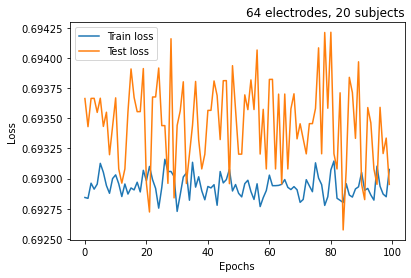

In [313]:
plt.plot(train_losses, label='Train loss')
plt.plot(valid_losses, label='Test loss')
plt.legend()
plt.title("64 electrodes, 20 subjects", loc='right')
plt.xlabel("Epochs")
plt.ylabel("Loss")

Text(0, 0.5, 'Percentage')

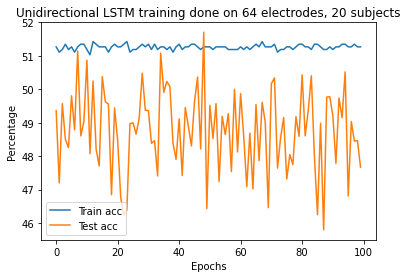

In [314]:
plt.plot(train_accuracies, label='Train acc')
plt.plot(valid_accuracies, label='Test acc')
plt.legend()
plt.title("Unidirectional LSTM training done on 64 electrodes, 20 subjects")
plt.xlabel("Epochs")
plt.ylabel("Percentage")